<a href="https://colab.research.google.com/github/estasko/comp_bio_final_project_2024/blob/main/mini_proj_1_new_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project One
Ella Stasko 10.02.2024

---
The program loads the dataset which is comprised of DNA sequences as input to predict STARR-seq activity. It is loaded and preprocessed as it is in Eugene's basic usage tutorial.

Two new models are created and compared against Eguene's Hybrid model

To create the new models many sources were used.

1.   EUGENe's GitHub documentation: https://github.com/ML4GLand/EUGENe/tree/main/eugene
2.   PyTorch Documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
3. ChatGPT was used to troubleshoot input and output values of each layer in the original function



**Mount to drive and Load data**

In [2]:
# Load package and mount to drive
!pip install 'eugene-tools'
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/EUGENe")
cwd = os.getcwd()
cwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/EUGENe'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/EUGENe'

In [3]:
# Configure EUGENe directories
from eugene import settings
settings.config_dir = "./tutorial_configs" # Directory to specify when you want to load a model from a config file
settings.dataset_dir = "./tutorial_dataset" # Directory where EUGENe will download datasets to
settings.logging_dir = "./tutorial_logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "./tutorial_output" # Directory where EUGENe will save output files to
settings.figure_dir = "./tutorial_figures" # Directory to specify to EUGENe to save figures to

In [4]:
# Import data
import seqdatasets
sdata = seqdatasets.jores21(dataset="leaf")
sdata

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.
Zarr file found. Opening zarr file.


<xarray.Dataset>
Dimensions:     (_sequence: 72158, _length: 170)
Dimensions without coordinates: _sequence, _length
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(1000, 170), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>

**Preprocess Data**

In [5]:
# Preprocess data by one hot encoding
from eugene import preprocess as pp
pp.ohe_seqs_sdata(sdata, alphabet="DNA")
# Make unique ids for each sequence in the sdata
pp.make_unique_ids_sdata(sdata)

In [6]:
# More data preprocessing -> data set needs to be split into separate training and testing data sets
# Split into train and test sets
sdata_train = sdata.sel(_sequence=(sdata["set"] == "train").compute())
sdata_test = sdata.sel(_sequence=(sdata["set"] == "test").compute())

# The training set then needs to be split into training and validation
pp.train_test_random_split(sdata_train, dim="_sequence", train_var="train_val", test_size=0.4)

**Initialize and Instantiate:**  After loading the data, we will initialize and instantiate each model.

In [7]:
# Initialize Hybrid model used in Basic Usage Tutorial for comparison against new models
# download model from original assignment ("Hybrid")
from eugene import models
!mkdir -p $cwd/tutorial_configs
!wget https://raw.githubusercontent.com/ML4GLand/tutorials/main/configs/hybrid.yaml -O $cwd/tutorial_configs/hybrid.yaml


--2024-10-02 13:52:48--  https://raw.githubusercontent.com/ML4GLand/tutorials/main/configs/hybrid.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 719 [text/plain]
Saving to: ‘/content/drive/MyDrive/EUGENe/tutorial_configs/hybrid.yaml’

/content/drive/MyDr 100%[===================>]     719  --.-KB/s    in 0s      

2024-10-02 13:52:48 (44.2 MB/s) - ‘/content/drive/MyDrive/EUGENe/tutorial_configs/hybrid.yaml’ saved [719/719]



In [8]:
# Import packages to create new models
from eugene.models.base import _layers as layers
import torch
import torch.nn as nn
from eugene.models._SequenceModule import SequenceModule


In [9]:
# Create Class of original model
# Model consists of convolutional layers, ReLU functions, Pooling layers and Linear layers
class OriginalModel(nn.Module):
    def __init__(self, input_len: int = 4, output_dim: int = 1):
        super(OriginalModel, self).__init__()

        # Define layers
        self.layers = nn.Sequential(
            nn.Conv1d(input_len, 128, kernel_size=15),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(128, 64, kernel_size=15),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(64 * ((170 - 15 + 1) // 2 - 15 + 1) // 2, 128),  # Calculate input size so that it matches output
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

        self.input_len = input_len
        self.output_dim = output_dim

    def forward(self, x):
        return self.layers(x)

model_original = SequenceModule(OriginalModel())
model_original.summary()

Model: OriginalModel
Sequence length: 4
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: None
	Scheduler parameters: {}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | arch         | OriginalModel | 393 K  | train
1 | train_metric | R2Score       | 0      | train
2 | val_metric   | R2Score       | 0      | train
3 | test_metric  | R2Score       | 0      | train
-------------------------------------------------------
393 K     Trainable params
0         Non-trainable params
393 K     Total params
1.573     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode

In [10]:
# Load new model from Eugene with adjustable parameters (jores21cnn)
from eugene.models.zoo._cre_activity_predictors import Jores21CNN
# Must pass model to this function to run
from eugene.models._SequenceModule import SequenceModule

jores = Jores21CNN(input_len = 170, output_dim = 1, filters = 100, kernel_size = 15, layers = 2, stride = 1, dropout = 0.3, hidden_dim = 30)
model_jores = SequenceModule(jores)

In [11]:
model_jores.summary()

Model: Jores21CNN
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: None
	Scheduler parameters: {}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | arch         | Jores21CNN | 816 K  | train
1 | train_metric | R2Score    | 0      | train
2 | val_metric   | R2Score    | 0      | train
3 | test_metric  | R2Score    | 0      | train
----------------------------------------------------
816 K     Trainable params
0         Non-trainable params
816 K     Total params
3.266     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode

In [12]:
# Instance of hybrid model
model_h = models.load_config("hybrid.yaml")

In [13]:
model_h.summary()

Model: Hybrid
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {'patience': 2}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | arch         | Hybrid  | 1.9 M  | train
1 | train_metric | R2Score | 0      | train
2 | val_metric   | R2Score | 0      | train
3 | test_metric  | R2Score | 0      | train
-------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.703     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode

In [14]:
# Initialize weights of hybrid model
models.init_weights(model_h)

# Initialize weights of jores  model
models.init_weights(model_jores)

# Initialize weights of original 1 model
models.init_weights(model_original)

**Train Data**

In [15]:
# Model fitting
from eugene import train

In [16]:
train.fit_sequence_module(
    model = model_original,
    sdata=sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=25,
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False,
    name="original",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)},
    gpus=1
)

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


No seed set


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/EUGENe/tutorial_logs/original/tutorial_model/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | arch         | OriginalModel | 393 K  | train
1 | train_metric | R2Score       | 0      | train
2 | val_metric   | R2Score       | 0      | train
3 | test_metric  | R2Score       | 0      | train
-------------------------------------------------------
393 K     Trainable params
0         Non-tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_

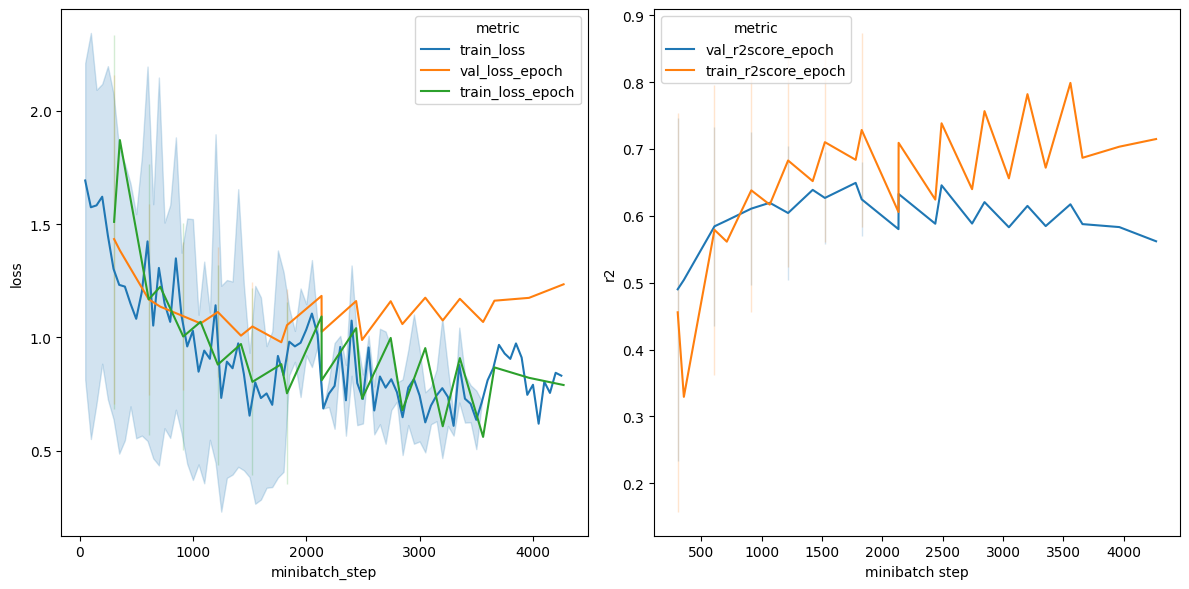

In [17]:
# Plot a loss curve and an r2 curve as a metric
from eugene import plot as pl
pl.training_summary(os.path.join(settings.logging_dir, "original", "tutorial_model"), metric="r2")

In [18]:
train.fit_sequence_module(
    model = model_jores,
    sdata=sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=25,
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False,
    name="jores",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)},
    gpus=1
)

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/EUGENe/tutorial_logs/jores/tutorial_model/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VI

No seed set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_

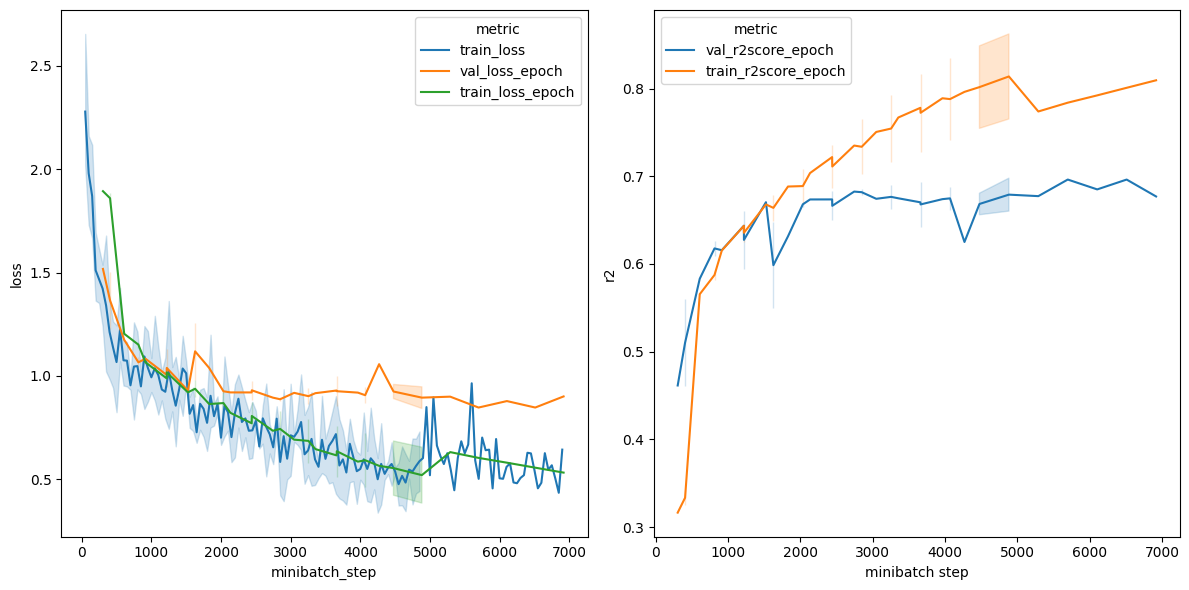

In [19]:
# Plot a loss curve and an r2 curve as a metric
from eugene import plot as pl
pl.training_summary(os.path.join(settings.logging_dir, "jores", "tutorial_model"), metric="r2")

In [20]:
train.fit_sequence_module(
    model=model_h,
    sdata=sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=25,
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False,
    name="hybrid",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)},
    gpus=1
)

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | arch         | Hybrid  | 1.9 M  | train
1 | train_m

No seed set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

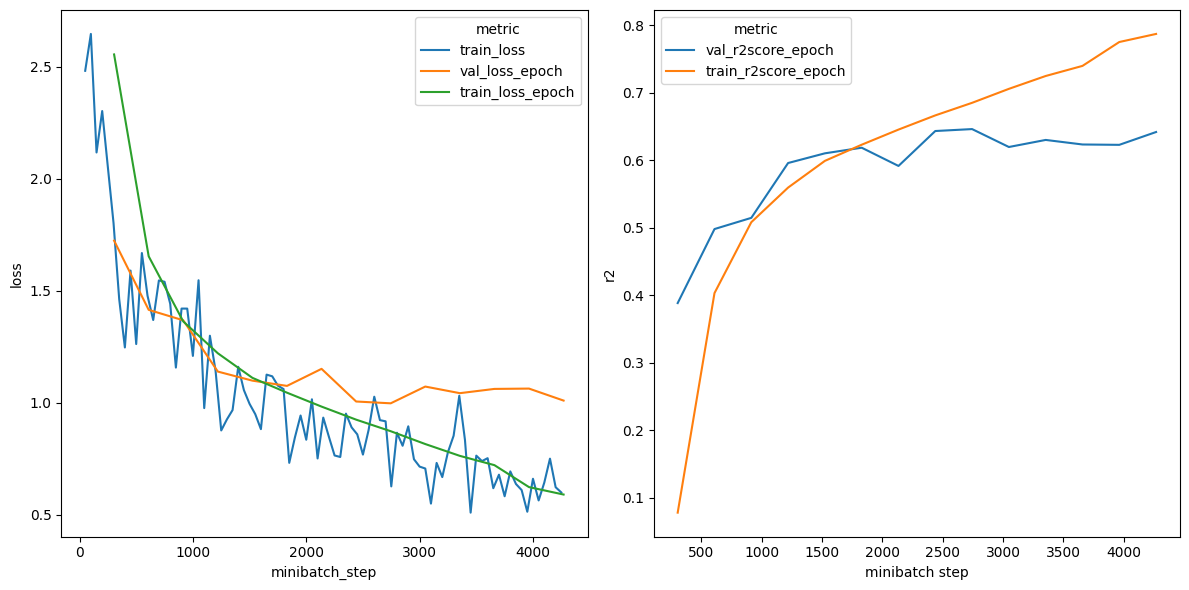

In [21]:
# Plot a loss curve and an r2 curve as a metric
from eugene import plot as pl
pl.training_summary(os.path.join(settings.logging_dir, "hybrid", "tutorial_model"), metric="r2")

**Evaluation**

From the graphs shown above, it is clear that all models exhibit over training. EUGENe's "Hybrid" performs the best, it has the least amount of overtraining. The original model created has more overtraining and a much less predictable slope and is jagged. The jores model looks to be even more overtrained then the original model created but with less unpredictability in its slope.   

In order to improve the developed models, more time must be spent adjusting parameters and layer configurations. The breakdown of training and validation data was also adjusted to improve overtraining (though changing from 0.2 to 0.4 created the instances of jagged r2scores in the jores and original model)